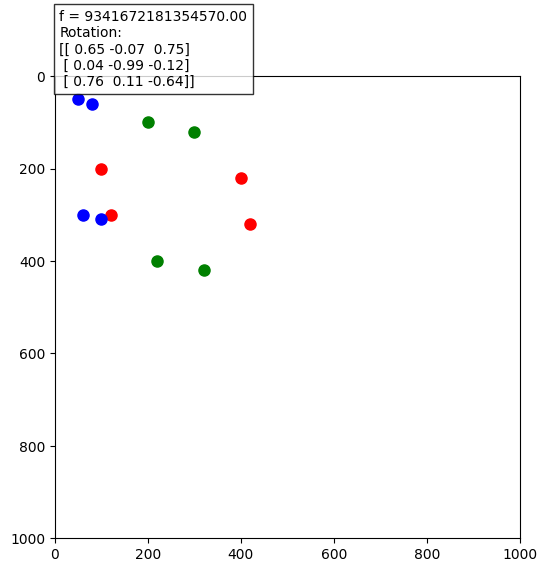

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Compute vanishing point from two or more lines (each line = two points)
def compute_vanishing_point(lines):
    A = []
    for (x1, y1), (x2, y2) in lines:
        a = y1 - y2
        b = x2 - x1
        c = x1*y2 - x2*y1
        A.append([a, b, c])
    A = np.array(A)
    _, _, Vt = np.linalg.svd(A)
    vp = Vt[-1]
    return vp / vp[2]

# 2. Estimate focal length from two orthogonal vanishing points
def estimate_focal_length(v1, v2, principal_point):
    u0, v0 = principal_point
    x1, y1 = v1[0] - u0, v1[1] - v0
    x2, y2 = v2[0] - u0, v2[1] - v0
    f2 = -(x1*x2 + y1*y2)
    if f2 <= 0:
        raise ValueError("Invalid configuration, cannot solve focal length")
    return np.sqrt(f2)

# 3. Compute orientation (rotation matrix)
def compute_camera_orientation(vps, f, principal_point):
    u0, v0 = principal_point
    K = np.array([[f, 0, u0],
                  [0, f, v0],
                  [0, 0, 1]])
    Kinv = np.linalg.inv(K)

    dirs = []
    for vp in vps:
        d = Kinv @ np.array([vp[0], vp[1], 1.0])
        d /= np.linalg.norm(d)
        dirs.append(d)
    
    x_axis = dirs[0]
    y_axis = dirs[1] - np.dot(dirs[1], x_axis) * x_axis
    y_axis /= np.linalg.norm(y_axis)
    z_axis = np.cross(x_axis, y_axis)
    z_axis /= np.linalg.norm(z_axis)

    R = np.column_stack((x_axis, y_axis, z_axis))
    return R

# 4. Full calibration pipeline
def calibrate_camera(lines_by_axis, principal_point):
    vps = [compute_vanishing_point(lines) for lines in lines_by_axis]
    f = estimate_focal_length(vps[0], vps[1], principal_point)
    R = compute_camera_orientation(vps, f, principal_point)
    return {"focal_length": f, "rotation": R, "vanishing_points": vps}


# ---------------- Interactive Demo in Jupyter ----------------
class DraggablePoint:
    def __init__(self, point, update_callback):
        self.point = point
        self.press = None
        self.update_callback = update_callback

    def connect(self):
        self.cidpress = self.point.figure.canvas.mpl_connect(
            'button_press_event', self.on_press)
        self.cidrelease = self.point.figure.canvas.mpl_connect(
            'button_release_event', self.on_release)
        self.cidmotion = self.point.figure.canvas.mpl_connect(
            'motion_notify_event', self.on_motion)

    def on_press(self, event):
        if event.inaxes != self.point.axes: return
        contains, _ = self.point.contains(event)
        if not contains: return
        x0, y0 = self.point.get_data()
        self.press = (x0[0], y0[0], event.xdata, event.ydata)

    def on_motion(self, event):
        if self.press is None or event.inaxes != self.point.axes: return
        x0, y0, xpress, ypress = self.press
        dx = event.xdata - xpress
        dy = event.ydata - ypress
        self.point.set_data([x0+dx], [y0+dy])
        self.update_callback()
        self.point.figure.canvas.draw()

    def on_release(self, event):
        self.press = None
        self.point.figure.canvas.draw()


class CalibrationVisualizer:
    def __init__(self, principal_point=(500, 500)):
        self.principal_point = principal_point

        # initial line sets (two lines per axis)
        self.lines_by_axis = [
            [((100, 200), (400, 220)), ((120, 300), (420, 320))],
            [((200, 100), (220, 400)), ((300, 120), (320, 420))],
            [((50, 50), (60, 300)), ((80, 60), (100, 310))]
        ]

        self.fig, self.ax = plt.subplots(figsize=(6,6))
        self.ax.set_xlim(0, 1000)
        self.ax.set_ylim(0, 1000)
        self.ax.invert_yaxis()

        colors = ['r','g','b']
        self.endpoints = []

        for axis_lines, c in zip(self.lines_by_axis, colors):
            for (x1,y1),(x2,y2) in axis_lines:
                p1, = self.ax.plot([x1],[y1], marker='o', color=c, markersize=8)
                p2, = self.ax.plot([x2],[y2], marker='o', color=c, markersize=8)
                self.endpoints.append((p1,p2,c))

        self.textbox = self.ax.text(10, 20, "", fontsize=10, color='k',
                                    bbox=dict(facecolor='white', alpha=0.8))

        self.drags = []
        for p1,p2,_ in self.endpoints:
            dp1 = DraggablePoint(p1, self.update)
            dp2 = DraggablePoint(p2, self.update)
            dp1.connect(); dp2.connect()
            self.drags.append(dp1); self.drags.append(dp2)

        self.update()

    def update(self):
        # extract updated endpoints
        updated_lines = []
        for p1, p2, c in self.endpoints:
            (x1,),(y1,) = p1.get_data()
            (x2,),(y2,) = p2.get_data()
            updated_lines.append(((x1,y1),(x2,y2)))

        # regroup into 3 axes (2 lines each)
        grouped = [updated_lines[i*2:(i+1)*2] for i in range(3)]

        try:
            calib = calibrate_camera(grouped, self.principal_point)
            msg = f"f = {calib['focal_length']:.2f}\n"
            msg += "Rotation:\n" + np.array2string(calib['rotation'], precision=2)
        except Exception as e:
            msg = f"Error: {e}"

        self.textbox.set_text(msg)
        self.fig.canvas.draw_idle()


if __name__ == "__main__":
    vis = CalibrationVisualizer()
